## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Parameters

In [2]:
sigma = 1.0  # Volatility
S0 = 100  # Initial price
q0 = 0      # Initial inventory
X0 = 0      # Initial cash
# k = 1
# j = 0.01    # Impact coefficient for prob function
gamma = 0.01  # Risk aversion penalty

## Specific functions

In [3]:
def f(x):
    return(1/2*np.exp(-x))

def Delta(lam):
    return max(0,lam+1)

def C(lam):
    if lam >= -1:
        return 1/2 * np.exp(-(lam+1))
    else:
        return -lam/2
    
def dp_step(q, V_qm1, V_q, V_qp1):
    return V_q - gamma/2 * q**2 + C(V_q - V_qm1) + C(V_q - V_qp1)

def fill_V(T):
    V = np.zeros((2*T+1, T+1))
    for n in reversed(range(T)):
        for q in range(T-n, T+n+1):
            V[q,n] = dp_step(q-T,V[q-1,n+1],V[q,n+1], V[q+1,n+1])
    return V


## Main simulation functions

In [4]:
def run_market_simulation(V, T=100, sigma=1.0, S0=100, gamma=0.01):
    q = np.zeros(T+1, dtype=int)
    c = np.zeros(T+1)
    cash = np.zeros(T+1)
    pnl = np.zeros(T+1)
    S = np.zeros(T+1)
    S[0] = S0
    
    for n in range(T):  
        delta_a_opt = Delta(V[q[n]+T,n+1] - V[q[n]+T-1,n+1]) 
        delta_b_opt = Delta(V[q[n]+T,n+1] - V[q[n]+T+1,n+1])
        p_ask_opt = f(delta_a_opt)
        p_bid_opt = f(delta_b_opt)
        p_none_opt = 1 - p_ask_opt - p_bid_opt
        event_opt = np.random.choice(['ask', 'bid', 'none'], p=[p_ask_opt, p_bid_opt, p_none_opt])
        eta_a_opt = 1 if event_opt == 'ask' else 0
        eta_b_opt = 1 if event_opt == 'bid' else 0
        q[n+1] = q[n] - eta_a_opt + eta_b_opt
        cash[n+1] = cash[n] + eta_a_opt * (S[n] + delta_a_opt) - eta_b_opt * (S[n] - delta_b_opt)
        c[n] = delta_a_opt * eta_a_opt + delta_b_opt * eta_b_opt - gamma/2 * q[n]**2 #idea de Carlos *2
        pnl[n+1] = cash[n+1] + S[n] * q[n+1]
        S[n+1] = S[n]+np.random.normal(0,sigma)
    c_sum = sum(c)
    return c_sum, pnl


def simulate_multiple_runs(num_simulations=10000, T=100):
    sigma = 1.0
    S0 = 100
    gamma = 0.01
    V = fill_V(T)
    cs = np.zeros(num_simulations)
    pnls = np.zeros((num_simulations, T+1))
    for i in range(num_simulations):
        cs[i], pnls[i, :] = run_market_simulation(V, T, sigma, S0, gamma)
    return cs, pnls

## Simulation Results

In [5]:
T = 30
V = fill_V(T=T)
cs, pnls = simulate_multiple_runs(num_simulations=10000, T=T)

In [6]:
print("Mean total cost over simulations:", np.mean(cs))
print("Optimal total cost:", V[T,0])
print("Relative error:", np.round(np.abs(np.mean(cs) - V[T,0]) / np.abs(V[T,0]) * 100, 2), "%")

Mean total cost over simulations: 10.469348617647723
Optimal total cost: 10.47863194925423
Relative error: 0.09 %


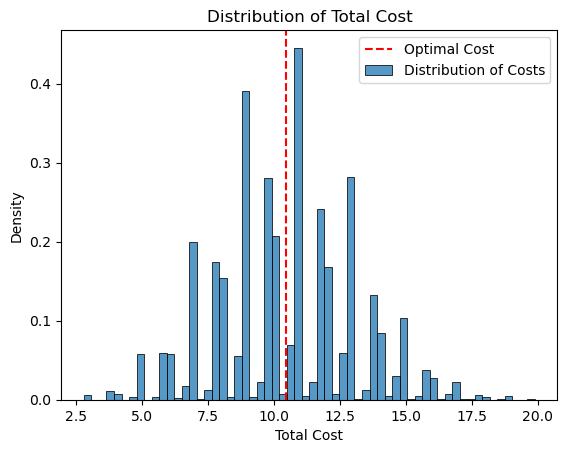

In [7]:
ax = sns.histplot(cs, bins='auto', label="Distribution of Costs", stat='density')
ax.axvline(fill_V(T=T)[T,0], color='r', linestyle='--', label='Optimal Cost')
ax.set_title('Distribution of Total Cost')
ax.set_xlabel('Total Cost')
ax.set_ylabel('Density')
ax.legend()
plt.show()

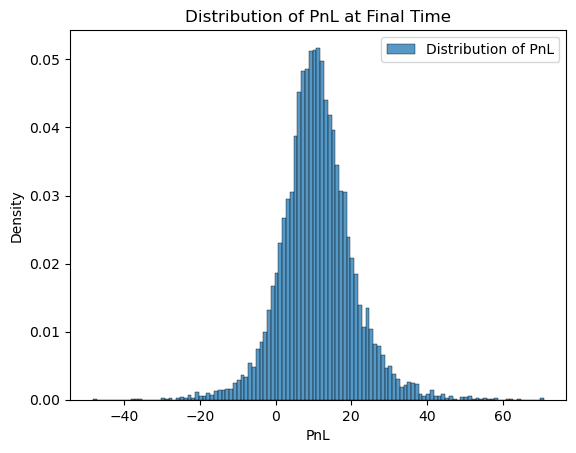

In [8]:
ax = sns.histplot(pnls[:, -1], bins='auto', label="Distribution of PnL", stat='density')
ax.set_title('Distribution of PnL at Final Time')
ax.set_xlabel('PnL')
ax.set_ylabel('Density')
ax.legend()
plt.show()